# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 28.02.2024

Мягкий дедлайн: 19.03.2024 23:59 MSK

Жёсткий дедлайн: 25.03.2024 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/60281

Username — ваша фамилия и имя на латинице именно в таком порядке

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [1]:
import numpy as np
from scipy.special import expit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
seed = 0xDEADF00D
np.random.seed(seed)

In [2]:
L = np.load('L.npy')
n, m = L.shape

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои.

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [3]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [4]:
def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    beta_reshaped = beta.reshape(-1, 1)
    alpha_reshaped = alpha.reshape(1, -1)

    gamma_t1 = (L == 1) * (-softplus(-beta_reshaped @ alpha_reshaped))
    gamma_t0 = (L == 0) * (-softplus(-beta_reshaped @ alpha_reshaped))

    gamma_t1 = np.exp(np.log(0.5) + np.sum(gamma_t1 + (L != 1) * (-softplus(beta_reshaped @ alpha_reshaped)), axis = 1))
    gamma_t0 = np.exp(np.log(0.5) + np.sum(gamma_t0 + (L != 0) * (-softplus(beta_reshaped @ alpha_reshaped)), axis = 1))

    norm = gamma_t0 + gamma_t1 + 1e-8

    return np.array([gamma_t0 / norm, gamma_t1 / norm])

def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    beta_reshaped = beta.reshape(-1, 1)
    alpha_reshaped = alpha.reshape(1, -1)

    expit_positive = expit(beta_reshaped @ alpha_reshaped)
    expit_negative = expit(-beta_reshaped @ alpha_reshaped)

    g1 = q[1] * beta @ ((L== 1) * expit_negative - (L != 1) * expit_positive)
    g0 = q[0] * beta @ ((L == 0) * expit_negative - (L != 0) * expit_positive)

    g = g1 + g0

    return g


def logbeta_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt beta
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    beta_reshaped = beta.reshape(-1, 1)
    alpha_reshaped = alpha.reshape(1, -1)

    expit_positive = expit(beta_reshaped @ alpha_reshaped)
    expit_negative = expit(-beta_reshaped @ alpha_reshaped)

    g1 = q[1].reshape(-1, 1) @ alpha_reshaped * ((L == 1) * expit_negative - (L != 1) * expit_positive)
    g0 = q[0].reshape(-1, 1) @ alpha_reshaped * ((L == 0) * expit_negative - (L != 0) * expit_positive)

    g = np.sum(g1 + g0, axis = 1) * beta

    return g


In [5]:
def em(L, n_steps=1000, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    #correct_tags_array = np.array([3] * (n - 10) + list(y[-10:]))
    for step in range(n_steps):
        posterior = posterior(alpha, np.exp(logbeta), L)
        ga = alpha_grad_lb(alpha, np.exp(logbeta), L, posterior)
        gb = logbeta_grad_lb(alpha, np.exp(logbeta), L, posterior)
        alpha += lr * ga
        logbeta += lr * gb
    return alpha, np.exp(logbeta), q

In [6]:
alpha, beta, q = em(L)

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$).

In [7]:
y = np.load('y.npy')
tags = [np.random.binomial(1, i) for i in q[0]]
acc = accuracy_score(y, np.array(tags))
if acc < 0.5:
    tags = [1 - tag for tag in tags]
    alpha = -alpha
    acc = 1 - acc
print(acc)

0.935


**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли врено размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

In [8]:
accuracies = np.array([(L[:, i] == y).mean() for i in range(L.shape[1])])

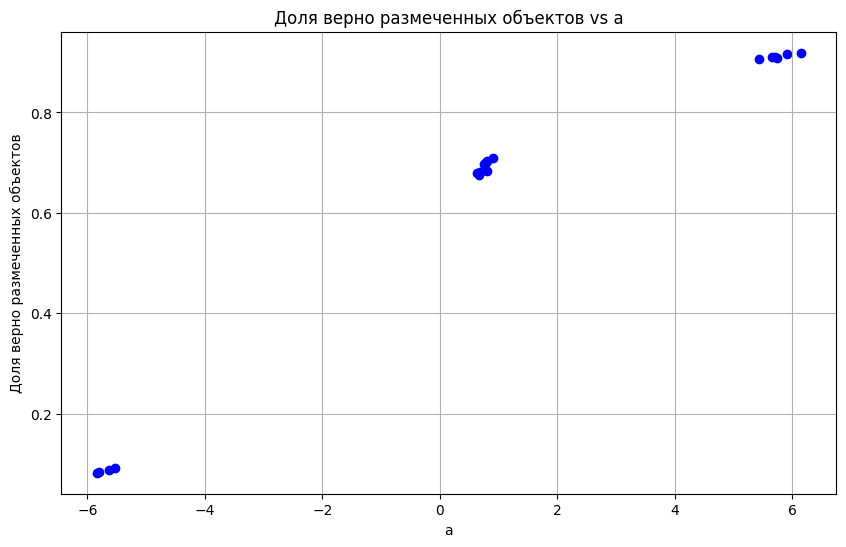

In [9]:
plt.figure(figsize = (10, 6))
plt.scatter(-alpha, accuracies, color='blue')
plt.title('Доля верно размеченных объектов vs a')
plt.xlabel('a')
plt.ylabel('Доля верно размеченных объектов')
plt.grid(True)
plt.show()

У экспертов с отрицательными значениями a наблюдается значительно меньшая доля правильных ответов. С другой стороны, по мере увеличения a, доля правильных ответов возрастает. Т.е. а можно интерпретировать как меру точности оценок экспертов.

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

In [209]:
def posterior_correct(alpha, beta, L, correct_labels):
    beta = np.array(beta)
    correct_labels = np.array(correct_labels)
    gamma1 = np.log(0.5) + np.sum((L == 1) * (-softplus(-alpha * beta[:, None])) + (L != 1) * (-softplus(alpha * beta[:, None])), axis=1)
    gamma0 = np.log(0.5) + np.sum((L == 0) * (-softplus(-alpha * beta[:, None])) + (L != 0) * (-softplus(alpha * beta[:, None])), axis=1)
    exp_gamma0 = np.exp(gamma0)
    exp_gamma1 = np.exp(gamma1)
    probs0 = exp_gamma0 / (exp_gamma0 + exp_gamma1)
    probs1 = exp_gamma1 / (exp_gamma0 + exp_gamma1)
    probs0[correct_labels == 0] = 1
    probs1[correct_labels == 1] = 1
    return np.stack([probs0, probs1], axis=0)

In [ ]:
def em_correct(L, y, n_steps=1000, lr=1e-3):
    m, n = L.shape
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    correct_labels = np.concatenate([np.full(n - 10, 3), y[-10:]])
    for step in range(n_steps):
        beta = np.exp(logbeta)
        posterior = posterior_correct(alpha, beta, L, correct_labels)
        alpha += lr * alpha_grad_lb(alpha, beta, L, posterior)
        logbeta += lr * logbeta_grad_lb(alpha, beta, L, posterior)
    return alpha, np.exp(logbeta), q

In [211]:
alpha, beta, q = em_correct(L, y)

In [212]:
tags = [np.random.binomial(1, i) for i in q[0]]
acc = accuracy_score(y, np.array(tags))
if acc < 0.5:
    tags = [1 - tag for tag in tags]
    alpha = -alpha
    acc = 1 - acc
print(acc)

0.9425


Качество стало чуть лучше, поскольку теперь в ыыборку включен вопрос с заведомо известным ответом, а еще больше не нужно менять метки классов, что удобно.

# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно).

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [13]:
%%bash
# wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

In [140]:
import glob
from preprocessing import extract_sentences

all_sentences = []
all_targets = []

In [144]:
for filename in glob.glob('data/*/*/*.wa'):
    st = extract_sentences(filename)

    all_sentences.extend(st[0])
    all_targets.extend(st[1])

In [145]:
t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

In [146]:
t_idx_src

{'!': 0,
 '"': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 '&amp;': 6,
 "'": 7,
 "''": 8,
 "'d": 9,
 "'em": 10,
 "'ll": 11,
 "'m": 12,
 "'n'": 13,
 "'re": 14,
 "'s": 15,
 '(': 16,
 ')': 17,
 ',': 18,
 '-': 19,
 '--': 20,
 '-LRB-': 21,
 '-LSB-': 22,
 '-RRB-': 23,
 '-RSB-': 24,
 '.': 25,
 '...': 26,
 '/': 27,
 '0': 28,
 '0.01': 29,
 '0.5': 30,
 '0.89': 31,
 '000': 32,
 '1': 33,
 '1,118': 34,
 '1-for-17': 35,
 '1.1': 36,
 '1.13': 37,
 '1.16': 38,
 '1.23': 39,
 '1.25': 40,
 '1.26': 41,
 '1.27': 42,
 '1.39': 43,
 '1.4': 44,
 '1.41': 45,
 '1.43': 46,
 '1.45': 47,
 '1.46': 48,
 '1.47': 49,
 '1.5': 50,
 '1.50': 51,
 '1.55': 52,
 '1.7': 53,
 '1.75': 54,
 '1.8': 55,
 '1.82': 56,
 '1.85': 57,
 '1.9': 58,
 '1/2': 59,
 '1/4': 60,
 '10': 61,
 '10,000': 62,
 '10-day': 63,
 '10-year': 64,
 '10.05': 65,
 '10.72': 66,
 '100': 67,
 '101': 68,
 '102': 69,
 '103': 70,
 '103.1': 71,
 '104.75': 72,
 '1069': 73,
 '109': 74,
 '11': 75,
 '117': 76,
 '12': 77,
 '120': 78,
 '125': 79,
 '126': 80,
 '13': 81,
 '130': 8

**Задание -1. (0.5 балла)** Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

In [59]:
from preprocessing import get_token_to_index, tokenize_sents

In [60]:
t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности.

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [63]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая.

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели.

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

In [64]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8115275584918071

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

Перед выпонлением задания я смотрела это видео: https://www.youtube.com/watch?v=5etGx8OZE7I

# E-step (expectation)

$$
   p(A|T, S) = \frac{p(A, T|S)}{p(T|S)}
$$

$$
   p(T|S) = \sum_{A}{p(T, A|S)} = \sum_{A}{\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})}
$$

$$
   \frac{p(A, T|S)}{p(T|S)}= \frac{\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})}{\sum_{A}{\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})}} = \frac{\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i})}{\prod_{i=1}^m {\sum_{j=1}^n \frac{1}{n}\theta(t_i|s_{j})}} =    \prod_{i=1}^m{\frac{\theta(t_i|s_{a_i})}{\sum_{j=1}^n\theta(t_i|s_{j})}}
$$

# M-step (maximization)

$$
c(t|s; T, S) = \frac{\theta(t|s)}{\sum_{i=0}^{n} \theta(t|s_i)} \sum_{j=1}^{m} \delta(t, t_j) \sum_{i=0}^{n} \delta(s, s_i)
$$

$$

\theta(t|s) = \frac{\sum_{(t,s)}с(t|s, T, S)}{\sum_{t}\sum_{s}с(t|s, T, S)}

$$

# Нижняя оценка правдоподобия

По определению
$$
L=\mathbb{E}_{q^*}[log\prod_{k}\frac{p(A_k, T|S, \theta)}{q_k(A_k)}]
$$
Распишем как сумму
$$
=\sum_{k}[\mathbb{E}_{q^*}[log\frac{p(A_k, T|S, \theta)}{q_k^{*}(A_k)}]]=
$$
$$
=\sum_{k}\sum_{i=1}^{m_k}[\mathbb{E}{q_k^*}[log(\frac{1}{n_k}\theta(t_i|s{a_i})) - \mathbb{E}{q_k^*}log\frac{\theta(t_i|s{a_i})}{\sum_{k=1}^{n_k}\theta(t_i|s_{k})}]]=
$$
Подставим формулу из Е-шага
$$
\sum_{k}\sum_{i=1}^{m_k}\sum_{j=1}^{n_k}\frac{\theta(t_i|s_{j})}{\sum_{j=1}^{n_k}\theta(t_i|s_{j})}[log(\frac{1}{n_k}\theta(t_i|s_{a_i})) - log\frac{\theta(t_i|s_{a_i})}{\sum_{j=1}^{n_k}\theta(t_i|s_{j})}] 
$$
Как логарифм
$$
\log\left(\frac{1}{n_k}\theta(t_i|s_{a_i})\right) - \log\left(\frac{\theta(t_i|s_{a_i})}{\sum_{j=1}^{n_k}\theta(t_i|s_{j})}\right) = \log\left(\frac{\frac{1}{n_k}\theta(t_i|s_{a_i})}{\frac{\theta(t_i|s_{a_i})}{\sum_{j=1}^{n_k}\theta(t_i|s_{j})}}\right) = \log\left(\frac{\sum_{j=1}^{n_k}\theta(t_i|s_{j})}{n_k}\right)
$$
$$
\sum_{k}\sum_{i=1}^{m_k}\sum_{j=1}^{n_k}\frac{\theta(t_i|s_{j})}{\sum_{j=1}^{n_k}\theta(t_i|s_{j})}[\log\left(\frac{\sum_{j=1}^{n_k}\theta(t_i|s_{j})}{n_k}\right)] 
$$

**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

In [148]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences);

# ༼つ ಠ益ಠ༽つ ─=≡ΣO))

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [149]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [150]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['Pan', 'řekl', 'pan']

In [69]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [70]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [71]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['konec', 'dne', 'S']

In [72]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['.', 'se', 'na']

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

In [151]:
stokens = np.concatenate([ts.source_tokens for ts in tokenized_sentences])
ttokens = np.concatenate([ts.target_tokens for ts in tokenized_sentences])

In [152]:
scount = np.bincount(stokens, minlength = len(t_idx_src))
tcount = np.bincount(ttokens, minlength = len(t_idx_tgt))

In [153]:
spr = scount / scount.sum()
tpr = tcount / tcount.sum()

In [154]:
pr = (word_aligner.translation_probs * spr[:, np.newaxis]) / np.where(tpr > 0, tpr, 1)

In [155]:
idx_token_src = {index: token for token, index in t_idx_src.items()}

In [87]:
[idx_token_src[i] for i in pr[:,t_idx_tgt['paní']].argsort()[-3:]]

['Mann', 'lady', 'Mrs']

In [86]:
[idx_token_src[i] for i in pr[:,t_idx_tgt['pan']].argsort()[-3:]]

['organist', 'schoolmaster', 'Mr']

In [82]:
[idx_token_src[i] for i in pr[:,t_idx_tgt['vody']].argsort()[-3:]]

['volume', 'reimmersion', 'water']

**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

## Alignment

In [241]:
sent = all_sentences[100]
ns = len(sent.source)
nt = len(sent.target)

In [236]:
aligned_pairs = np.array(word_aligner.align([tokenize_sents([sent], t_idx_src, t_idx_tgt)[0]])[0]) - 1

In [237]:
matrix = np.zeros(ns, nt)
for x, y in aligned_pairs:
    matrix[x, y] = 1

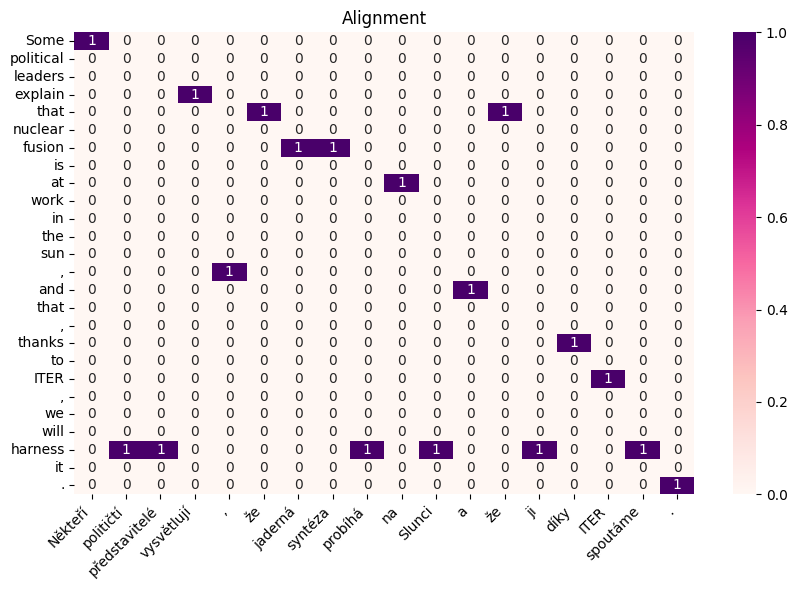

In [240]:
plt.figure(figsize = (10, 6))
sns.heatmap(matrix, cmap = 'RdPu', annot = True, xticklabels = sent.target, yticklabels = sent.source)
plt.title('Alignment')
plt.xticks(rotation = 45, ha = "right")
plt.show()

In [242]:
tsent = tokenize_sents([sent], t_idx_src, t_idx_tgt)[0]

## Posterior Probabilities

In [251]:
matrix = word_aligner.translation_probs[np.ix_(tsent.source_tokens, tsent.target_tokens)]

In [252]:
matrix = np.divide(matrix, matrix.sum(axis = 0, keepdims = True))
matrix = np.round(matrix, 2)

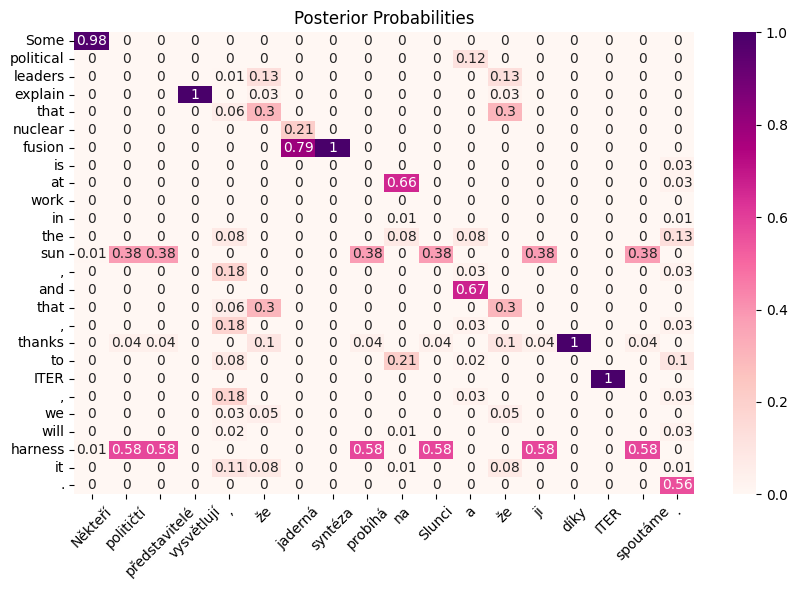

In [253]:
plt.figure(figsize = (10, 6))
sns.heatmap(matrix, cmap = 'RdPu', annot = True, xticklabels = sent.target, yticklabels = sent.source)
plt.title('Posterior Probabilities')
plt.xticks(rotation = 45)
plt.show()

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

**Задание 7. (1 балл)** В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [131]:
import unicodedata
normalized_sentences = []
for pair in all_sentences:
    normalized_source = [unicodedata.normalize('NFC', word).lower() for word in pair.source]
    normalized_target = [unicodedata.normalize('NFC', word).lower() for word in pair.target]
    normalized_pair = SentencePair(source = normalized_source, target = normalized_target)
    normalized_sentences.append(normalized_pair)

In [134]:
t_idx_src, t_idx_tgt = get_token_to_index(normalized_sentences)
tokenized_sentences = tokenize_sents(normalized_sentences, t_idx_src, t_idx_tgt)

In [135]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences)

[-911214.0528643727,
 -695792.579489708,
 -655695.8742742538,
 -636558.1404622346,
 -626685.2610694617,
 -621205.0923969895,
 -617939.104762964,
 -615873.9346560985,
 -614505.7477876246,
 -613565.1284689307,
 -612898.3463729471,
 -612413.0806851313,
 -612051.6551733166,
 -611776.8784887493,
 -611564.0848408788,
 -611396.5471099019,
 -611262.6556307003,
 -611154.2254017368,
 -611065.368730858,
 -610991.7916338444]

In [136]:
compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8328621597486663